In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tqdm import tqdm
import json
import pickle
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler
from lightautoml.validation.np_iterators import TimeSeriesIterator


In [2]:
X = pickle.load(open("../data/preprocessed/features.pkl", "rb"))

In [3]:
sot = pd.read_csv("../data/raw/sotrudniki.csv", sep=";", parse_dates=["date"])

In [4]:
new_X = pd.merge(X, sot[['hash_tab_num', 'date', "sick"]], on=['hash_tab_num', 'date'], how="left")

In [5]:
X.shape, sot.shape, new_X.shape

((111287, 171), (99214, 23), (111287, 172))

In [6]:
def add_rolling_features(X, window=12):
    X = X.copy().drop("sick", axis=1)
    
    # fill nans
    cat_feats = X.select_dtypes(include=['category']).columns
    for col in cat_feats:
        try:
            X[col] = X[col].cat.add_categories("nan").fillna("nan")
        except:
            X[col] = X[col].fillna("nan")
        
    float_feats = X.select_dtypes(include=['float64', "int64"]).columns
    for col in float_feats:
        X[col] = X[col].fillna(X[col].mean()).fillna(-100)
    
    cols_for_merge = ["date", "hash_tab_num"]
    list_to_concat = []
    for idx in tqdm(X["hash_tab_num"].unique()):
        # date
        this_sot = X[X["hash_tab_num"]==idx].set_index("date")
#         this_sot["shifted_sick"] = this_sot["sick"].shift(-1).fillna(0)
        for col in cat_feats:
            this_sot[col] = this_sot[col].rank(method='dense')
        roll = this_sot.rolling(window, min_periods=1)
        
        real_mean = roll[float_feats].mean().rename(lambda x: f"float_mean_win{window}_{x}", axis=1)
        real_max = roll[float_feats].max().rename(lambda x: f"float_max_win{window}_{x}", axis=1)
        real_min = roll[float_feats].min().rename(lambda x: f"float_min_win{window}_{x}", axis=1)
        
        cat_count = roll[cat_feats].count().rename(lambda x: f"cat_cnt_win{window}_{x}", axis=1)
        cat_count_unique = roll[cat_feats].apply(lambda x: len(set(x))).fillna(0).rename(lambda x: f"cat_ucnt_win{window}_{x}", axis=1)
        
        
        res_df = pd.concat([
            this_sot[["hash_tab_num"]],
            real_mean, real_max, real_min,
            cat_count, cat_count_unique,
        ], axis=1)
        
#         res_df["sick_prev_count"] = roll["shifted_sick"].sum()
        
        list_to_concat.append(res_df.reset_index())
#     return list_to_concat
    return pd.concat(list_to_concat, axis=0, ignore_index=True)

In [7]:
r = add_rolling_features(new_X)

100%|██████████| 2619/2619 [02:55<00:00, 14.92it/s]


In [8]:
r.shape

(111287, 496)

In [9]:
X_full = pd.merge(new_X, r, on=['hash_tab_num', 'date'], how="left")

In [10]:
X_train = X_full[~X_full["sick"].isna()]
X_test = X_full[X_full["sick"].isna()]

In [11]:
X_train.shape, X_test.shape

((90266, 666), (21021, 666))

In [12]:
def pandas_fill(arr):
    ser = pd.Series(arr)
    ser = ser.fillna(ser.mean())
    return ser.values

In [23]:
# # holdout split:
# X_ho = X_train[(X_train['date'] > '2018-08-01') & (X_train['date'] <= '2019-08-01')].copy()
# X_tr = X_train[~X_train.index.isin(X_ho.index)]

In [28]:
X_tr = X_train

In [29]:
X_train.shape, X_tr.shape, X_ho.shape

((90266, 666), (90266, 666), (22694, 666))

In [30]:



cat_cols = X_tr.select_dtypes(include=['category']).columns
X_tr[cat_cols] = X_tr[cat_cols].astype(str)

N_THREADS = 30 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TIMEOUT = 20000 # Time in seconds for automl run

task = Task('binary', )

roles = {
    'target': 'sick',
    'category': X_tr.select_dtypes(include=['category']).columns.tolist(),
    DatetimeRole(seasonality=("y", "m"), date_format='%Y-%m-%d', base_feats=True): 
        X_tr.select_dtypes(include=['datetime64']).columns.tolist(),
}

cv_iter = TimeSeriesIterator(X_tr["date"].astype(np.datetime64), n_splits=5, sorted_kfold=False)

automl = TabularAutoML(task = task, 
                   timeout = TIMEOUT,
                   cpu_limit = N_THREADS,
                   config_path="conf_5_sel_type_1_tuning_full.yml",
                   general_params = {
                       'use_algos': [['lgb', 'linear_l2', 'cb'], ['lgb']],
                   },
                   tuning_params= {
                       "max_tuning_iter": "auto",
                       "max_tuning_time": 10000,
                   },
                   reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(X_tr, roles = roles, cv_iter=cv_iter)

#     models.append(model)

p, r, thresholds = precision_recall_curve(X_tr["sick"], pandas_fill(oof_pred.data[:, 0]))
f1_scores = 2 * r * p / (r + p)
f1_scores = f1_scores[p > 0]
th = thresholds[np.argmax(f1_scores)]
print("Results: ", th, max(f1_scores))

Start automl preset with listed constraints:
- time: 20000 seconds
- cpus: 30 cores
- memory: 16 gb

Train data shape: (90266, 666)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 19960.02383375168 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.729143216440541
Linear model: C = 5e-05 score = 0.7367235490711684
Linear model: C = 0.0001 score = 0.7381496228821567
Linear model: C = 0.0005 score = 0.7373248946867278
Linear model: C = 0.001 score = 0.7353322236614933

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7242187208958596
Linear model: C = 5e-05 score = 0.7309139885414656
Linear model: C = 0.0001 score = 0.7324105309998252
Linear model: C = 0.0005 score = 0.7314836132652711
Linear model: C = 0.001 score = 0.7298583473517016

===== Start working with fold 2 for Lvl_0_Pi

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.754263
[200]	valid's auc: 0.759355
[300]	valid's auc: 0.762445
[400]	valid's auc: 0.764867
[500]	valid's auc: 0.767721
[600]	valid's auc: 0.770058
[700]	valid's auc: 0.771453
[800]	valid's auc: 0.773675
[900]	valid's auc: 0.774662
[1000]	valid's auc: 0.775768
[1100]	valid's auc: 0.776903
[1200]	valid's auc: 0.777274
Did not meet early stopping. Best iteration is:
[1172]	valid's auc: 0.777308

===== Start working with fold 3 for Lvl_1_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.768005
[200]	valid's auc: 0.772459
[300]	valid's auc: 0.775946
[400]	valid's auc: 0.778356
[500]	valid's auc: 0.781024
[600]	valid's auc: 0.78341
[700]	valid's auc: 0.785105
[800]	valid's auc: 0.786049
[900]	valid's auc: 0.787886
[1000]	valid's auc: 0.788994
[1100]	valid's auc: 0.789919
[1200]	valid's auc: 0.79054
Did not meet early stopping. Best iteration is:
[11

In [27]:
# ho_pred = automl.predict(X_ho).data[:, 0]
# f1_score(X_ho["sick"], (ho_pred > th).astype('int'))

0.3162639048714998

In [34]:
sub_pred = automl.predict(X_test).data[:, 0]

In [32]:
sub = X_test[['hash_tab_num', 'date']].copy()
sub['target'] = (sub_pred > th).astype('int')
sub.to_csv('../data/submissions/sub_aml_windf_lgb_cb_lin_notune.csv', index=False, sep=';')

In [33]:

task = Task('binary', )

roles = {
    'target': 'sick',
    'category': X_tr.select_dtypes(include=['category']).columns.tolist(),
    DatetimeRole(seasonality=("y", "m"), date_format='%Y-%m-%d', base_feats=True): 
        X_tr.select_dtypes(include=['datetime64']).columns.tolist(),
}

cat_cols = X_tr.select_dtypes(include=['category']).columns
X_tr[cat_cols] = X_tr[cat_cols].astype(str)

N_THREADS = 30 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TIMEOUT = 20000 # Time in seconds for automl run



cv_iter = TimeSeriesIterator(X_tr["date"].astype(np.datetime64), n_splits=5, sorted_kfold=False)

automl = TabularAutoML(task = task, 
                   timeout = TIMEOUT,
                   cpu_limit = N_THREADS,
                   config_path="conf_5_sel_type_1_tuning_full.yml",
                   general_params = {
                       'use_algos': [['lgb_tuned', 'linear_l2', 'cb_tuned']],
                   },
                   tuning_params= {
                       "max_tuning_iter": "auto",
                       "max_tuning_time": 10000,
                   },
                   reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(X_tr, roles = roles, cv_iter=cv_iter)

#     models.append(model)

p, r, thresholds = precision_recall_curve(X_tr["sick"], pandas_fill(oof_pred.data[:, 0]))
f1_scores = 2 * r * p / (r + p)
f1_scores = f1_scores[p > 0]
th = thresholds[np.argmax(f1_scores)]
print("Results: ", th, max(f1_scores))

Start automl preset with listed constraints:
- time: 20000 seconds
- cpus: 30 cores
- memory: 16 gb

Train data shape: (90266, 666)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 19958.678358078003 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7291384839427363
Linear model: C = 5e-05 score = 0.7367126657734644
Linear model: C = 0.0001 score = 0.7381526910458709
Linear model: C = 0.0005 score = 0.7373906286470624
Linear model: C = 0.001 score = 0.7352448967753947

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7242187360148935
Linear model: C = 5e-05 score = 0.7309601620712061
Linear model: C = 0.0001 score = 0.7323602450928455
Linear model: C = 0.0005 score = 0.7315630486697428
Linear model: C = 0.001 score = 0.7298856220889811

===== Start working with fold 2 for Lvl_0_

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.767564
[200]	valid's auc: 0.768326
[300]	valid's auc: 0.767431
Early stopping, best iteration is:
[141]	valid's auc: 0.769496
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739276
[200]	valid's auc: 0.734905
Early stopping, best iteration is:
[40]	valid's auc: 0.741415

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749728
[200]	valid's auc: 0.747655
[300]	valid's auc: 0.742832
Early stopping, best iteration is:
[100]	valid's auc: 0.749728

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc

0:	learn: 0.6274952	test: 0.6351650	best: 0.6351650 (0)	total: 5.15ms	remaining: 7.72s
100:	learn: 0.7488271	test: 0.7413269	best: 0.7413528 (96)	total: 439ms	remaining: 6.08s
200:	learn: 0.7652486	test: 0.7417430	best: 0.7418391 (172)	total: 835ms	remaining: 5.39s
300:	learn: 0.7836148	test: 0.7417557	best: 0.7421759 (242)	total: 1.22s	remaining: 4.87s
bestTest = 0.7421759367
bestIteration = 242
Shrink model to first 243 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6604363	test: 0.6567848	best: 0.6567848 (0)	total: 4.53ms	remaining: 6.79s
100:	learn: 0.7469721	test: 0.7366466	best: 0.7366466 (100)	total: 409ms	remaining: 5.66s
200:	learn: 0.7561530	test: 0.7381510	best: 0.7381510 (200)	total: 809ms	remaining: 5.23s
300:	learn: 0.7663183	test: 0.7391122	best: 0.7392680 (298)	total: 1.21s	remaining: 4.81s
400:	learn: 0.7755182	test: 0.7404140	best: 0.7404889 (388)	total: 1.61s	remaining: 4.4s
500:	learn: 0.7849906	test: 0.7408678	best: 

1100:	learn: 0.7923588	test: 0.7397367	best: 0.7400544 (1054)	total: 3.99s	remaining: 1.45s
1200:	learn: 0.7964135	test: 0.7400516	best: 0.7401330 (1137)	total: 4.35s	remaining: 1.08s
bestTest = 0.7401330173
bestIteration = 1137
Shrink model to first 1138 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6533505	test: 0.6626202	best: 0.6626202 (0)	total: 4.1ms	remaining: 6.15s
100:	learn: 0.7393277	test: 0.7443885	best: 0.7443885 (100)	total: 366ms	remaining: 5.06s
200:	learn: 0.7452533	test: 0.7466156	best: 0.7466156 (200)	total: 759ms	remaining: 4.91s
300:	learn: 0.7500246	test: 0.7477100	best: 0.7477247 (299)	total: 1.21s	remaining: 4.82s
400:	learn: 0.7539330	test: 0.7481930	best: 0.7482264 (387)	total: 1.64s	remaining: 4.48s
500:	learn: 0.7586264	test: 0.7488132	best: 0.7488597 (494)	total: 2.05s	remaining: 4.09s
600:	learn: 0.7624553	test: 0.7496589	best: 0.7496589 (600)	total: 2.42s	remaining: 3.62s
700:	learn: 0.7662120	test: 0.7500

0:	learn: 0.6267097	test: 0.6335141	best: 0.6335141 (0)	total: 4.06ms	remaining: 6.09s
100:	learn: 0.7396165	test: 0.7398705	best: 0.7399053 (99)	total: 361ms	remaining: 5s
200:	learn: 0.7507256	test: 0.7406953	best: 0.7407214 (178)	total: 793ms	remaining: 5.13s
bestTest = 0.7407214046
bestIteration = 178
Shrink model to first 179 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6597202	test: 0.6585685	best: 0.6585685 (0)	total: 4.05ms	remaining: 6.07s
100:	learn: 0.7412568	test: 0.7341757	best: 0.7341757 (100)	total: 361ms	remaining: 5s
200:	learn: 0.7476518	test: 0.7359619	best: 0.7360815 (195)	total: 720ms	remaining: 4.65s
300:	learn: 0.7537606	test: 0.7371056	best: 0.7371056 (300)	total: 1.07s	remaining: 4.27s
400:	learn: 0.7596712	test: 0.7377284	best: 0.7378247 (388)	total: 1.49s	remaining: 4.08s
500:	learn: 0.7660348	test: 0.7383740	best: 0.7384199 (490)	total: 1.95s	remaining: 3.88s
600:	learn: 0.7710711	test: 0.7389196	best: 0.738

700:	learn: 0.7753072	test: 0.7392188	best: 0.7392910 (694)	total: 2.6s	remaining: 2.96s
800:	learn: 0.7799135	test: 0.7393624	best: 0.7394866 (778)	total: 2.97s	remaining: 2.6s
bestTest = 0.7394866347
bestIteration = 778
Shrink model to first 779 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6858447	test: 0.6957785	best: 0.6957785 (0)	total: 4.34ms	remaining: 6.5s
100:	learn: 0.7386441	test: 0.7433687	best: 0.7433687 (100)	total: 380ms	remaining: 5.27s
200:	learn: 0.7448376	test: 0.7456668	best: 0.7456668 (200)	total: 762ms	remaining: 4.92s
300:	learn: 0.7497206	test: 0.7467050	best: 0.7467293 (290)	total: 1.14s	remaining: 4.53s
400:	learn: 0.7537071	test: 0.7475928	best: 0.7475941 (395)	total: 1.51s	remaining: 4.15s
500:	learn: 0.7580244	test: 0.7482598	best: 0.7483268 (495)	total: 1.89s	remaining: 3.77s
600:	learn: 0.7617726	test: 0.7489735	best: 0.7489735 (600)	total: 2.26s	remaining: 3.38s
700:	learn: 0.7655353	test: 0.7497120	best

400:	learn: 0.7830686	test: 0.7496688	best: 0.7496715 (399)	total: 1.75s	remaining: 4.8s
500:	learn: 0.7940198	test: 0.7506434	best: 0.7506795 (492)	total: 2.19s	remaining: 4.37s
600:	learn: 0.8047102	test: 0.7513783	best: 0.7516623 (580)	total: 2.63s	remaining: 3.93s
bestTest = 0.7516623139
bestIteration = 580
Shrink model to first 581 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6946908	test: 0.7011060	best: 0.7011060 (0)	total: 5.46ms	remaining: 8.18s
100:	learn: 0.7494225	test: 0.7429291	best: 0.7429359 (99)	total: 452ms	remaining: 6.26s
200:	learn: 0.7595460	test: 0.7459016	best: 0.7459650 (199)	total: 896ms	remaining: 5.79s
300:	learn: 0.7687383	test: 0.7470835	best: 0.7470835 (300)	total: 1.34s	remaining: 5.34s
400:	learn: 0.7777663	test: 0.7480854	best: 0.7482329 (387)	total: 1.78s	remaining: 4.89s
500:	learn: 0.7865774	test: 0.7487609	best: 0.7487823 (473)	total: 2.23s	remaining: 4.45s
600:	learn: 0.7948301	test: 0.7499089	bes

In [27]:
# ho_pred = automl.predict(X_ho).data[:, 0]
# f1_score(X_ho["sick"], (ho_pred > th).astype('int'))

0.3162639048714998

In [35]:
sub_pred = automl.predict(X_test).data[:, 0]

In [36]:
sub = X_test[['hash_tab_num', 'date']].copy()
sub['target'] = (sub_pred > th).astype('int')
sub.to_csv('../data/submissions/sub_aml_windf_lgb_cb_lin_tuned.csv', index=False, sep=';')

In [40]:
pickle.dump(X_tr, open("../data/preprocessed/train_with_rolling.pkl", "wb"))
pickle.dump(X_test, open("../data/preprocessed/test_with_rolling.pkl", "wb"))

CPU times: user 74.6 ms, sys: 4.06 ms, total: 78.7 ms
Wall time: 76.5 ms


<AxesSubplot:xlabel='Feature'>

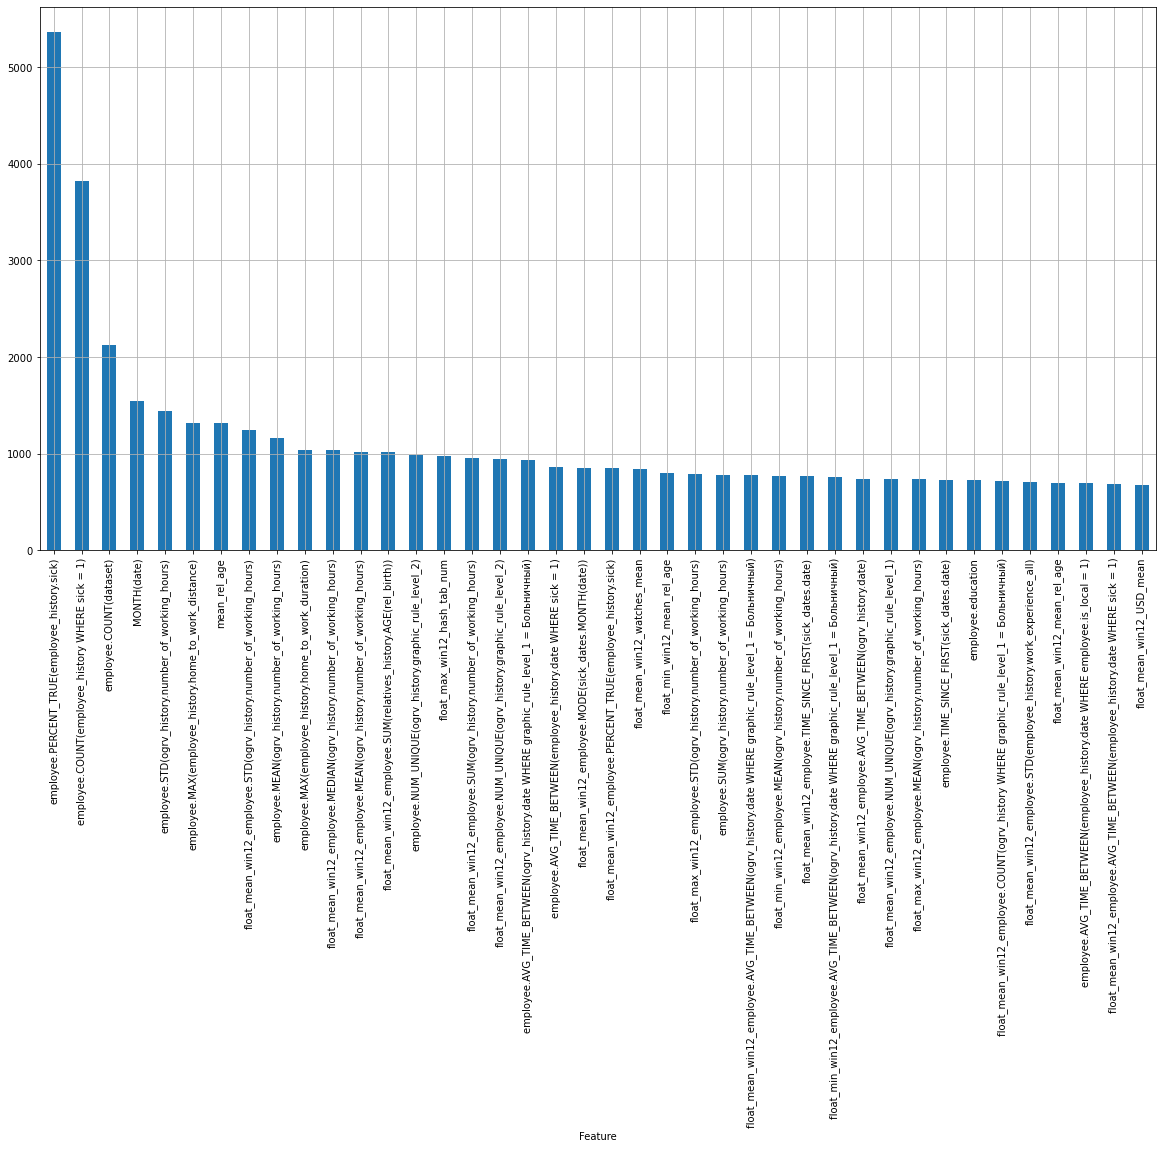

In [37]:

%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'][:40].plot.bar(figsize = (20, 10), grid = True)

In [27]:
fast_fi.set_index('Feature')['Importance']

Feature
float_mean_win12_sick                                                  39001.519429
float_max_win12_sick                                                   26162.291412
sick_prev_count                                                         9788.236088
MONTH(date)                                                             2312.785488
cat_cnt_win12_employee.MODE(employee_history.category)                  2033.748882
                                                                           ...     
float_max_win12_employee.NUM_UNIQUE(ogrv_history.MONTH(date))              0.000000
float_max_win12_employee.NUM_UNIQUE(ogrv_history.YEAR(date))               0.000000
float_min_win12_employee.MODE(employee_history.child_num)                  0.000000
float_max_win12_employee.NUM_UNIQUE(ogrv_history.work_shift_type)          0.000000
float_max_win12_employee.MEAN(sick_dates.TIME_SINCE_PREVIOUS(date))        0.000000
Name: Importance, Length: 663, dtype: float64